Simulação em Python de um modulador OFDM com as seguintes especificações:

- Subportadoras: 128
- Prefixo cíclico: 32
- Modulação: 4-QAM; 16-QAM
- Faixa de SNR (para o laço de repetição): -5:5:40
- Canal: AWGN

Faça o gráfico da taxa de erro de bit pela relação sinal-ruído, comparando as 2 modulações QAM.


In [41]:
# Import das bibliotecas necessárias
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft

# Plot da versão do numpy
print("numpy: ", np.__version__)

numpy:  2.1.3


In [42]:
# Parâmetros do sistema
num_subcarriers = 128

# Número de subportadoras piloto
cyclic_prefix_length = 32

# Vetor de SNR para o laço do calculo (menor, maior, passo)
# snr_range = np.arange(-5, 40, 5)

# Nota: Aqui utilizei um valor maior para melhorar a visualização do gráfico
snr_range = np.arange(-5, 41, 1)

# Número de símbolos OFDM utilizados para a transmissão/recepção
num_symbols = 1000

# Imprime os valores configurados (apenas para debug)
print("Número de subportadoras: ", num_subcarriers)
print("Número de subportadoras piloto: ", cyclic_prefix_length)
print("SNR: ", snr_range)
print("Número de símbolos OFDM: ", num_symbols)


Número de subportadoras:  128
Número de subportadoras piloto:  32
SNR:  [-5 -4 -3 -2 -1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18
 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
Número de símbolos OFDM:  1000


In [43]:
# Função para modular/demodular em QAM

# Parâmetros:
# M: número de símbolos da constelação
# data: vetor de dados a serem transmitidos
# Retorno: vetor de símbolos QAM
def qam_modulate(data, M):
    return np.sqrt(1/2) * (2*(data % np.sqrt(M)) - np.sqrt(M) + 1 + 1j*(2*(data // np.sqrt(M)) - np.sqrt(M) + 1))

def qam_demodulate(signal, M):

    # Calcula a parte real e imaginária do sinal
    real_part = np.real(signal)
    imag_part = np.imag(signal)

    # Calcula o índice do símbolo com base na parte real e imaginária
    real_part = np.round((real_part + np.sqrt(M) - 1) / 2).astype(int)
    imag_part = np.round((imag_part + np.sqrt(M) - 1) / 2).astype(int)
    return real_part + np.sqrt(M) * imag_part


In [44]:
# Função para modular/demodular em OFDM

# Parâmetros:
# data: vetor de dados a serem transmitidos
# num_subcarriers: número de subportadoras
# cyclic_prefix_length: tamanho do prefixo cíclico

# Retorno: vetor de símbolos OFDM
def ofdm_modulate(data, num_subcarriers, cyclic_prefix_length):

    # Calcula a transformada de Fourier inversa
    ofdm_symbols = ifft(data, num_subcarriers)

    # Adiciona o prefixo cíclico ao sinal
    cyclic_prefix = ofdm_symbols[:, -cyclic_prefix_length:]

    # Retorna o sinal OFDM
    return np.hstack([cyclic_prefix, ofdm_symbols])

def ofdm_demodulate(ofdm_signal, num_subcarriers, cyclic_prefix_length):

    # Remove o prefixo cíclico do sinal
    ofdm_signal = ofdm_signal[:, cyclic_prefix_length:]

    # Calcula a transformada de Fourier do sinal e retorna
    return fft(ofdm_signal, num_subcarriers)

In [45]:
# Função para adicionar ruído AWGN

# Parâmetros:
# signal: sinal a ser corrompido
# snr_db: relação

# Retorno: sinal corrompido
def add_awgn_noise(signal, snr_db):

    # Calcula o valor da SNR em escala linear
    snr_linear = 10**(snr_db / 10)

    # Calcula a potência do sinal através da média do módulo ao quadrado
    signal_power = np.mean(np.abs(signal)**2)

    # Calcula a potência do ruído
    noise_power = signal_power / snr_linear

    # Gera o ruído AWGN com a potência calculada
    noise = np.sqrt(noise_power / 2) * (np.random.randn(*signal.shape) + 1j * np.random.randn(*signal.shape))
    return signal + noise

In [46]:
# Função para calcular a BER

# Parâmetros:
# original_data: dados originais
# demodulated_data: dados demodulados

# Retorno: razão da BER
def calculate_ber(original_data, demodulated_data):

    # Calcula a média dos bits errados entre os dados originais e demodulados
    return np.mean(original_data != demodulated_data)


In [ ]:
# Criando um vetor para armazenar os valores de BER
ber_4qam = []

# Loop para cada valor de SNR
for snr in snr_range:

# Transmissão: 

    # Criando dados aleatórios para a modulação QAM
    data_4qam = np.random.randint(0, 4, (num_symbols, num_subcarriers))
    
    # Aplicando a modulação QAM aos dados gerados
    mod_data_4qam = qam_modulate(data_4qam, 4)


    ofdm_signal_4qam = ofdm_modulate(mod_data_4qam, num_subcarriers, cyclic_prefix_length)
    
# Canal: 
    # Adicionando ruído AWGN ao sinal OFDM modulado
    rx_signal_4qam = add_awgn_noise(ofdm_signal_4qam, snr)

# Recepção:

    # Demodulando o sinal OFDM recebido
    demod_data_4qam = ofdm_demodulate(rx_signal_4qam, num_subcarriers, cyclic_prefix_length)
    
    # Demodulando o sinal QAM recebido
    demod_data_4qam = qam_demodulate(demod_data_4qam, 4)
    
    # Calculando a BER e adicionando ao vetor de BER
    ber_4qam.append(calculate_ber(data_4qam, demod_data_4qam))


In [ ]:
# Criando um vetor para armazenar os valores de BER
ber_16qam = []

# Loop para cada valor de SNR
for snr in snr_range:

# Transmissão:
    
    # Criando dados aleatórios para a modulação 16-QAM
    data_16qam = np.random.randint(0, 16, (num_symbols, num_subcarriers))

    # Aplicando a modulação 16-QAM aos dados gerados
    mod_data_16qam = qam_modulate(data_16qam, 16)

    # Aplicando a modulação OFDM aos dados modulados
    ofdm_signal_16qam = ofdm_modulate(mod_data_16qam, num_subcarriers, cyclic_prefix_length)

# Canal: 
    # Adicionando ruído AWGN ao sinal OFDM modulado
    rx_signal_16qam = add_awgn_noise(ofdm_signal_16qam, snr)


# Recepção: 
    
    # Demodulando o sinal OFDM recebido
    demod_data_16qam = ofdm_demodulate(rx_signal_16qam, num_subcarriers, cyclic_prefix_length)

    # Demodulando o sinal QAM recebido
    demod_data_16qam = qam_demodulate(demod_data_16qam, 16)

    # Calculando a BER e adicionando ao vetor de BER
    ber_16qam.append(calculate_ber(data_16qam, demod_data_16qam))


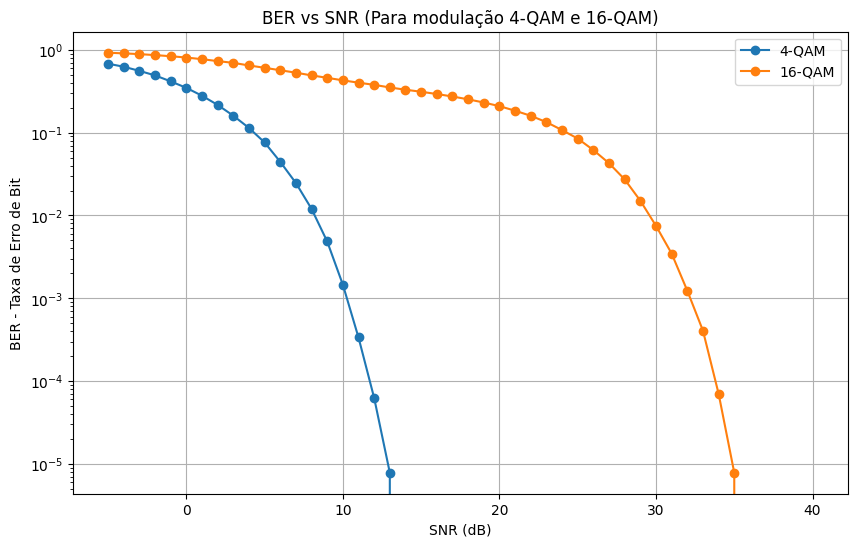

In [ ]:
# Plot dos resultados
plt.figure(figsize=(10, 6))

# Adicionando os dois vetores de dados ao gráfico
plt.semilogy(snr_range, ber_4qam, '-o', label='4-QAM')
plt.semilogy(snr_range, ber_16qam, '-o', label='16-QAM')

# Configurações do gráfico
plt.xlabel('SNR (dB)')
plt.ylabel('BER - Taxa de Erro de Bit')
plt.title('BER vs SNR (Para modulação 4-QAM e 16-QAM)')
plt.legend()
plt.grid(True)
plt.show()